In [2]:
from tqdm import tnrange
from squanch.agent import *
from squanch.gates import *
from squanch.qstream import * 
import numpy as np
import matplotlib.image as image
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Load the image 
imgData = image.imread("img/foundryLogo.bmp")

# Convert the image array to a bitstream
aliceData = np.unpackbits(imgData)
bobData = np.zeros(aliceData.size, dtype = np.uint8)

In [4]:
def showData():
    receivedArray = np.reshape(np.packbits(bobData), imgData.shape)
    f, ax = plt.subplots(1, 2, figsize = (8,4))
    ax[0].imshow(imgData)
    ax[0].axis('off')
    ax[0].title.set_text("Alice's image")
    ax[1].imshow(receivedArray)
    ax[1].axis('off')
    ax[1].title.set_text("Bob's image")
    plt.tight_layout()
    plt.show()

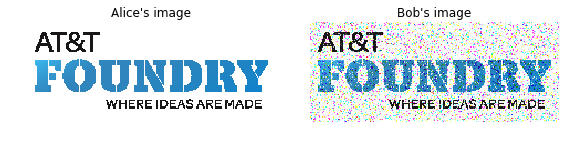

In [5]:
# Simulate sending an image with superdense coding over an Alice-Bob-Charlie system

size = len(aliceData) / 2 # Alice's image as a bitstream
stream = QStream(2, size)

alice = Agent("Alice") # Sender
bob = Agent("Bob") # Receiver
charlie = Agent("Charlie") # Pair distributor

connectAgents(alice, bob, length = 1.0) 
connectAgents(alice, charlie, length = 0.5)
connectAgents(bob, charlie, length = 0.5)

# Charlie creates and distributes |00> + |11> pairs between Alice and Bob
for _ in tnrange(size, desc = "Charlie distributes pairs"):
    a, b = stream.head().qubits
    H(a)
    CNOT(a,b)
    charlie.qsend(alice, a) 
    charlie.qsend(bob, b)

# Alice encodes her data in the sign and phase of her qubit and sends to Bob
for i in tnrange(size, desc = "Alice encodes data"):
    bit1, bit2 = aliceData[2*i], aliceData[2*i + 1]
    qubit = alice.qrecv(charlie)
    if qubit is not None:
        if bit2 == 1: X(qubit)
        if bit1 == 1: Z(qubit)
    alice.qsend(bob, qubit)

# Bob receives the qubits, disentangles them, and reconstructs Alice's data
for i in tnrange(size, desc = "Bob decodes data"):
    a = bob.qrecv(alice)
    c = bob.qrecv(charlie)
    if a is not None and c is not None:
        CNOT(a,c)
        H(a)
        bobData[2*i] = a.measure() 
        bobData[2*i + 1] = c.measure()
        
showData()